In [15]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
# 2. Load Dataset
df = pd.read_csv("x_en_dataset.csv")
df = df[df['sentiment'].notna()]
df['label'] = df['sentiment'].apply(lambda x: 1 if x > 0 else 0)

In [17]:
# 3. Preprocess Text
def preprocess(text):
    text = re.sub(r"http\S+", "", str(text).lower())
    return re.findall(r'\b\w+\b', text)

df['tokens'] = df['cleaned_text'].apply(preprocess)

In [18]:

# 4. Build Vocabulary
vocab = {}
for tokens in df['tokens']:
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab) + 1  

In [19]:
# 5. Load GloVe Embeddings
embedding_dim = 100
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

embedding_matrix = np.zeros((len(vocab)+1, embedding_dim))
for word, idx in vocab.items():
    vec = embedding_index.get(word)
    if vec is not None:
        embedding_matrix[idx] = vec

In [20]:
# 6. Tokenize & Pad Sequences
def encode(tokens): return [vocab.get(t, 0) for t in tokens]
def pad(seq, max_len=100): return seq[:max_len] + [0]*(max_len - len(seq))

df['input_ids'] = df['tokens'].apply(encode).apply(lambda x: pad(x, 100))

In [21]:
# 7. Create PyTorch Dataset
class SentimentDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    def __len__(self): return len(self.inputs)
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.labels[idx])

X_train, X_test, y_train, y_test = train_test_split(df['input_ids'].tolist(), df['label'].tolist(), test_size=0.2)
train_ds = SentimentDataset(X_train, y_train)
test_ds = SentimentDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

In [22]:
# 8. Define LSTM Model
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim=128, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        _, (hn, _) = self.lstm(x)
        return self.fc(self.dropout(hn[-1]))

In [23]:
# 9. Initialize Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentLSTM(len(vocab)+1, embedding_dim, embedding_matrix).to(device)

neg = df['label'].value_counts()[0]
pos = df['label'].value_counts()[1]
total = neg + pos

# Normalized weights
neg_weight = pos / total
pos_weight = neg / total
class_weights = torch.tensor([neg_weight, pos_weight], dtype=torch.float).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [24]:
# 10. Train the Model
train_losses = []
train_f1s = []

for epoch in range(5):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for inputs, labels in tqdm(train_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

    avg_loss = total_loss / len(train_dl)
    f1 = f1_score(all_labels, all_preds, average='macro')
    train_losses.append(avg_loss)
    train_f1s.append(f1)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f} - F1: {f1:.4f}")


100%|██████████| 125/125 [00:00<00:00, 323.98it/s]


Epoch 1 - Loss: 0.6953 - F1: 0.3659


100%|██████████| 125/125 [00:00<00:00, 529.43it/s]


Epoch 2 - Loss: 0.6938 - F1: 0.4402


100%|██████████| 125/125 [00:00<00:00, 486.33it/s]


Epoch 3 - Loss: 0.6934 - F1: 0.5006


100%|██████████| 125/125 [00:00<00:00, 488.93it/s]


Epoch 4 - Loss: 0.6935 - F1: 0.4912


100%|██████████| 125/125 [00:00<00:00, 506.32it/s]

Epoch 5 - Loss: 0.6936 - F1: 0.4897


In [25]:
# 11. Evaluate the Model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"\nFinal Test Accuracy: {acc*100:.2f}%")
print(f"Final Test F1 Score: {f1:.4f}")


Final Test Accuracy: 41.70%
Final Test F1 Score: 0.2943


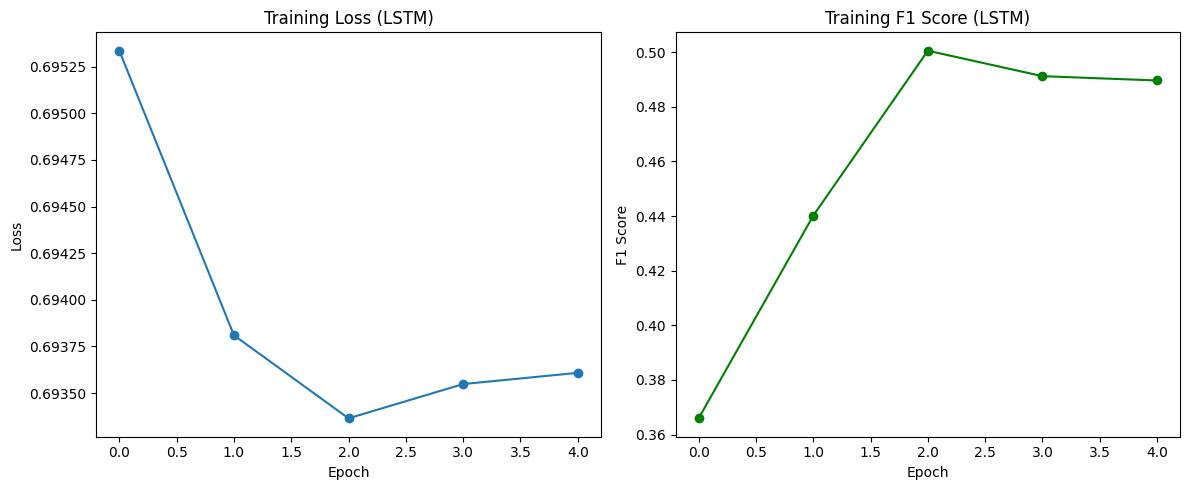

In [26]:
# 12. Plot Training Metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_f1s, marker='o', color='green')
plt.title("Training F1 Score (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()

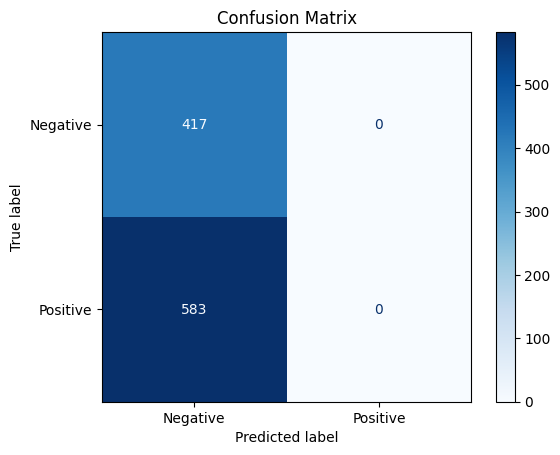

In [27]:
# 13. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()